# **LAB 2: PROBLEM OPTYMALIZACJI, SYMULACJA WYŻARZANIA - ADRIAN GLANOWSKI**

Importy:

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.datasets import make_blobs
from copy import copy, deepcopy
from PIL import Image


import networkx as nx



## **Problem komiwojażera**

### **Generowanie punktów**

Rozkład jednorodny

In [2]:
def uniform_distribution(n, lower = -1000.0, upper = 1000.0):
    return np.random.uniform(lower, upper, (n, 2))

Rozkład normalny

In [4]:
def normal_distribution(n, exp = 0, std = 100):
    return np.random.normal(exp, std, (n, 2))

Rozkład klastrowy

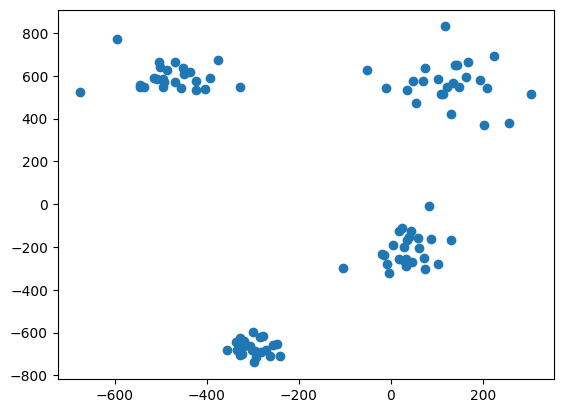

In [3]:
def cluster_distribution(n, k, lower=-1000.0, upper=1000.0):
    if k > n:
        raise ValueError("Number of clusters cannot be greater than number of points")
    
    centers = [(np.random.uniform(lower, upper), np.random.uniform(lower, upper)) for _ in range(k)]
    
    cluster_std = [np.random.uniform(0, 100) for _ in range(k)]
    
    points, _ = make_blobs(n_samples=n, centers=centers, cluster_std=cluster_std, n_features=2)
    
    return points

points = cluster_distribution(100, 4)
plt.scatter(points[:, 0], points[:, 1])  
plt.show()

Punkty na okręgu

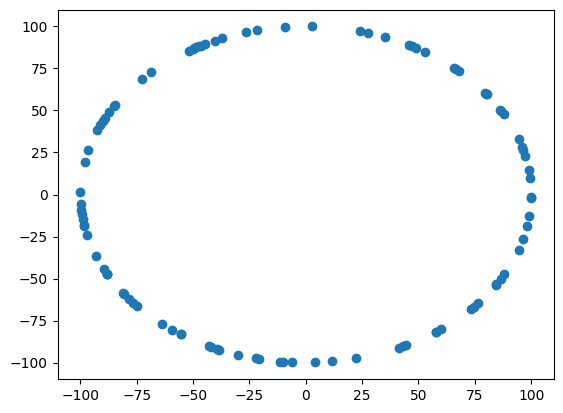

In [4]:
def circle_distribution(n, O = (0,0), R = 100):
    points = [0]*n
    for i in range(n):
        angle = np.random.uniform(0, 360)*np.pi/180
        points[i] = (O[0] + R*np.cos(angle), O[1] + R*np.sin(angle))
    return np.array(points).reshape((n, 2))

points = circle_distribution(100)
plt.scatter(points[:, 0], points[:, 1])  
plt.show()

In [5]:
def TSP(points, T0 = 100, B=0.999, big_switch = True, eps = 1e-36):
    if T0 < 0 or B < 0:
        raise ValueError

    def distance(point1, point2):
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    
    def total_path(points):
        sum_path = 0
        for i in range(n):
            sum_path += distance(points[i], points[(i-1)%n])
        
        return sum_path

    def temperature(T0, B, k):
        temp = T0*B**k
        return temp if temp > 0 else eps

    n = len(points)
    

    values = []
    args = []

    probs = []
    prob_args = []

    frames = []

    best_path = points
    sum_path = total_path(points)
    values.append(sum_path)
    args.append(0)
    
    best_pair = [0, sum_path]
    prob_usage = 1
    k = 1
    worse_cnt = 0

    while True:
        if big_switch:
            index1 = np.random.randint(0, n)
            index2 = np.random.randint(0, n)
            while index1 == index2:
                index1 = np.random.randint(0, n)
                index2 = np.random.randint(0, n)
            points[[index1, index2]] = points[[index2, index1]]
            
        else:
            index = np.random.randint(1, n)
            points[[index-1, index]] = points[[index, index-1]]
        
        new_sum_path = total_path(points)
        frames.append(copy(points))
        
        if new_sum_path < sum_path:
            values.append(new_sum_path)
            args.append(k)

            if new_sum_path < best_pair[1]:
                best_pair = [k, new_sum_path]
                best_path = deepcopy(points)
                worse_cnt = 0
                
            sum_path = new_sum_path
                
        else:
            temp = temperature(T0, B, k)
            
            prob = np.exp(-1/temp)
            probs.append(prob)
            prob_args.append(prob_usage)

            prob_usage += 1


            if prob < np.random.rand():
                if big_switch:
                    points[[index1, index2]] = points[[index2, index1]]
                else:
                    points[[index-1, index]] = points[[index, index-1]]

                if prob <= eps:  
                    worse_cnt += 1
                    if worse_cnt == n:
                        break
                
            else:
                values.append(new_sum_path)
                args.append(k)
                sum_path = new_sum_path
        k += 1
    
    return args, values, prob_args, probs, best_pair, best_path, frames

In [6]:
def make_gif(name, paths, big_switch):
    fig, ax = plt.subplots(figsize=(12, 12))

    def init():
        ax.clear()
        ax.set_title("TSP Optimization Progress")
        ax.set_xlim(np.min(points[:,0]) - 1, np.max(points[:,0]) + 1)
        ax.set_ylim(np.min(points[:,1]) - 1, np.max(points[:,1]) + 1)

    def update(frame):
        ax.clear()
        current_path = paths[frame]
        x = np.append(current_path[:, 0], current_path[0, 0])  # loop back to start
        y = np.append(current_path[:, 1], current_path[0, 1])
        
        ax.plot(x, y, 'b-', lw=2, label=f'Iter {frame}')
        ax.scatter(current_path[:, 0], current_path[:, 1], c='red')
        
        ax.set_title(f"TSP Iteration {frame}")
        ax.set_xlim(np.min(points[:,0]) - 1, np.max(points[:,0]) + 1)
        ax.set_ylim(np.min(points[:,1]) - 1, np.max(points[:,1]) + 1)
        ax.legend()

    ani = FuncAnimation(fig, update, frames=len(paths), init_func=init, repeat=False)

    # Save as GIF
    ani.save("TSP_gif/" + name + f"{"big" if big_switch else ""}.gif", writer=PillowWriter(fps=np.exp(1)))

In [7]:
PLOTS_CNT = 3
def draw_n_plots(n, points, big_switch):

    figure, axis = plt.subplots(n, 2, figsize=(15, 6*n))
    best_val = float('inf')
    for i in range(n):
        args, vals, prob_args, probs, best_pair, best_path, frames = TSP(copy(points), big_switch=big_switch)
        axis[i][0].plot(args, vals, "-")
        axis[i][0].plot(best_pair[0], best_pair[1], "go")
        axis[i][0].set_title("Distance")
        axis[i][0].set_xlabel("Iteration")
        axis[i][0].set_ylabel("Value")
        axis[i][0].legend(title=f"Best value = {best_pair[1]}")
        axis[i][0].set_xlim(left = 0)
        axis[i][0].set_ylim(bottom = 0)
        if best_pair[1] < best_val:
            best_val = best_pair[1]
            to_draw = frames

        axis[i][1].plot(prob_args, probs, "o", markersize=0.1)
        axis[i][1].set_title("Probability of accepting worse distance")
        axis[i][1].set_xlabel("Iteration")
        axis[i][1].set_ylabel("Probability")
        axis[i][1].set_xlim(left = 0)
    

    plt.suptitle(f"Using {"global swapping" if big_switch else "local swapping"}")
    plt.show()
    
    make_gif(f"{np.random.randint(0, 10000)}", to_draw, big_switch)

### **Przykłady**

C:\Users\Admin\AppData\Local\Temp\ipykernel_18468\2318948796.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


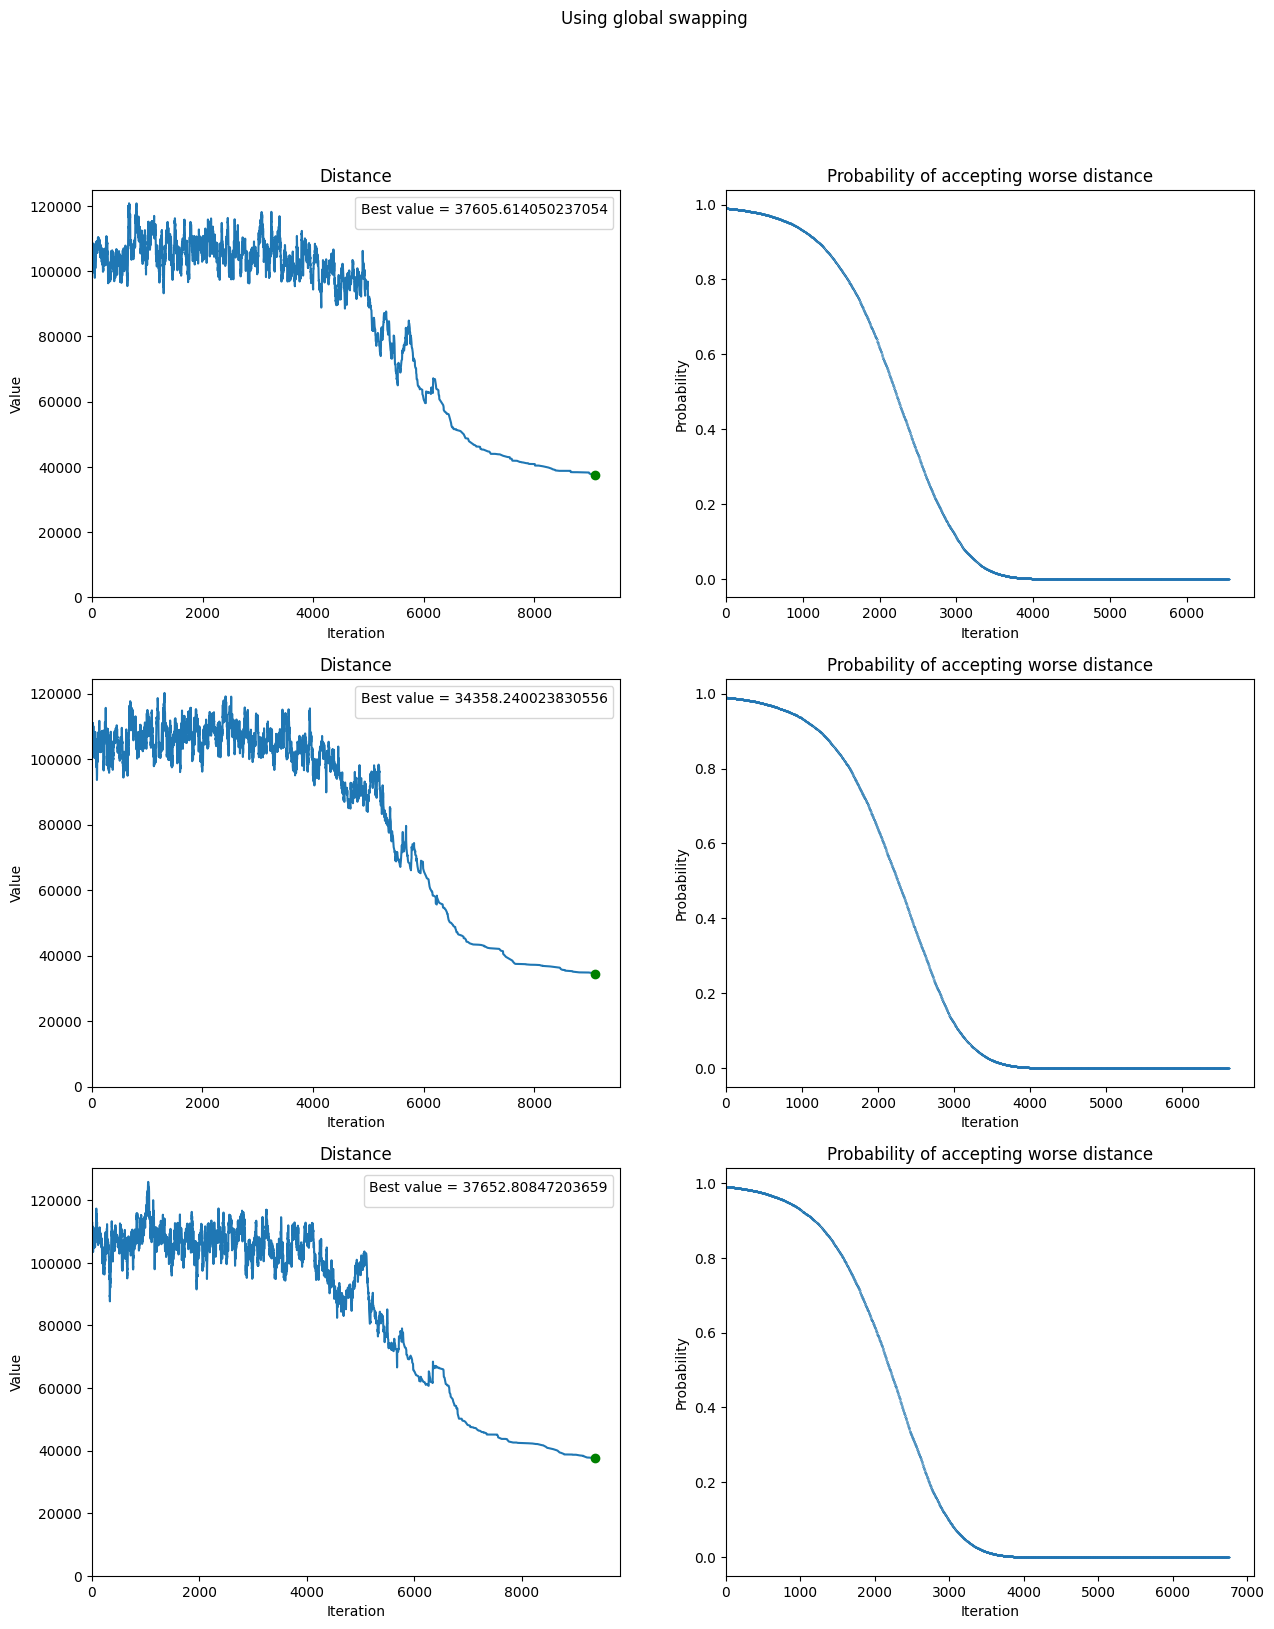

MemoryError: 

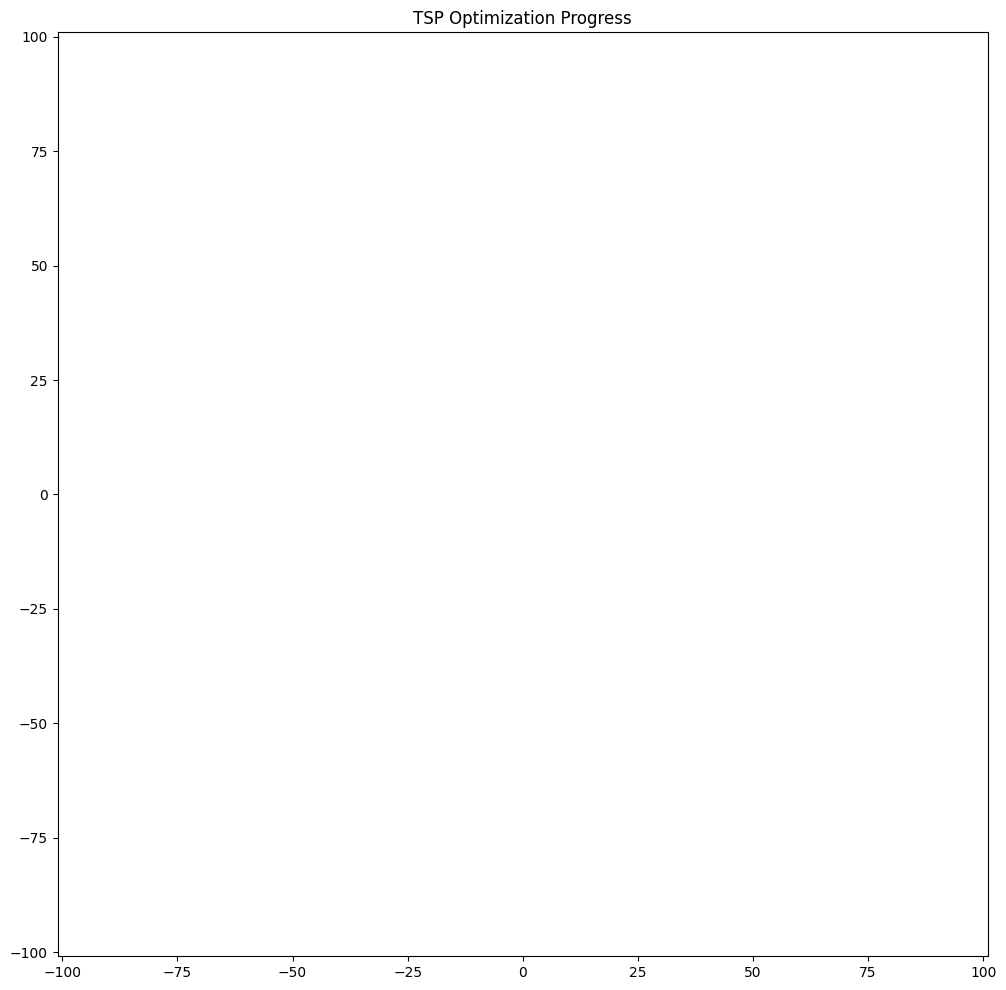

In [8]:
x = uniform_distribution(100)
draw_n_plots(3, x, True)
draw_n_plots(3, x, False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2932\3200498337.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


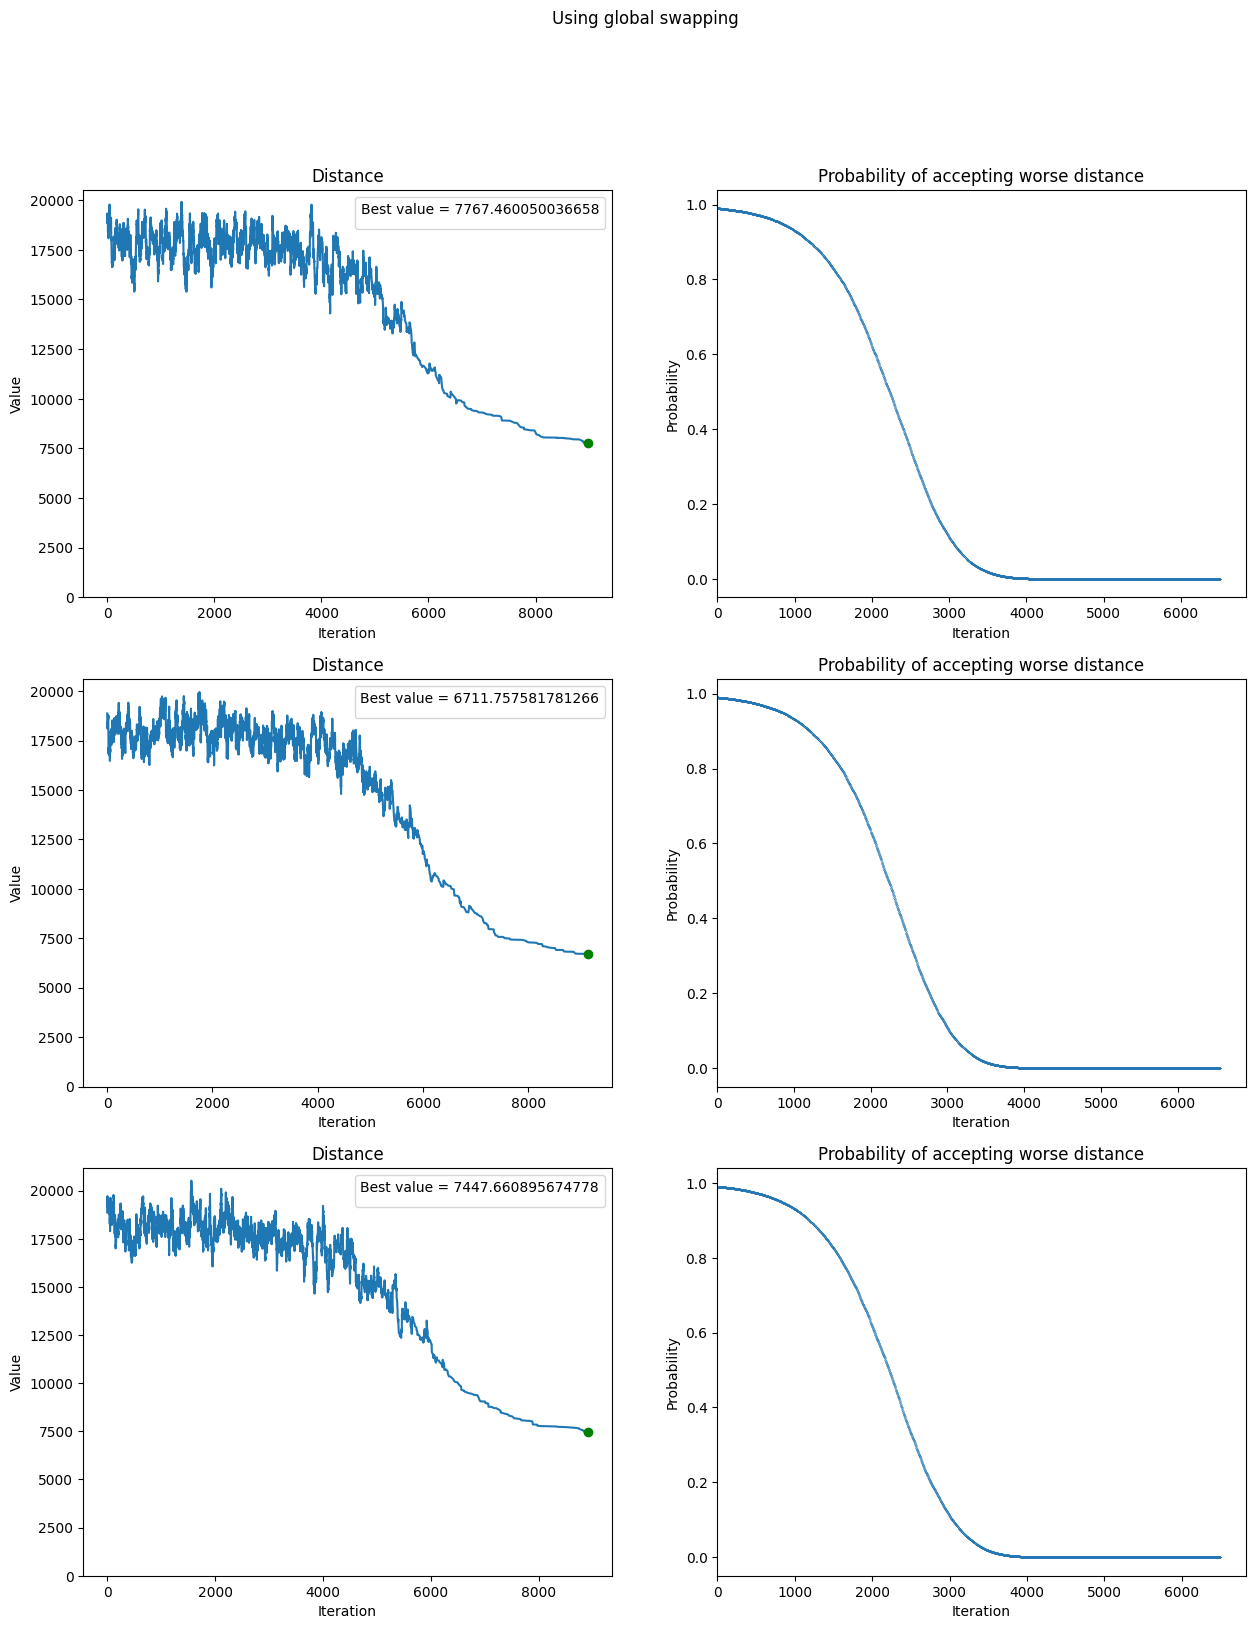

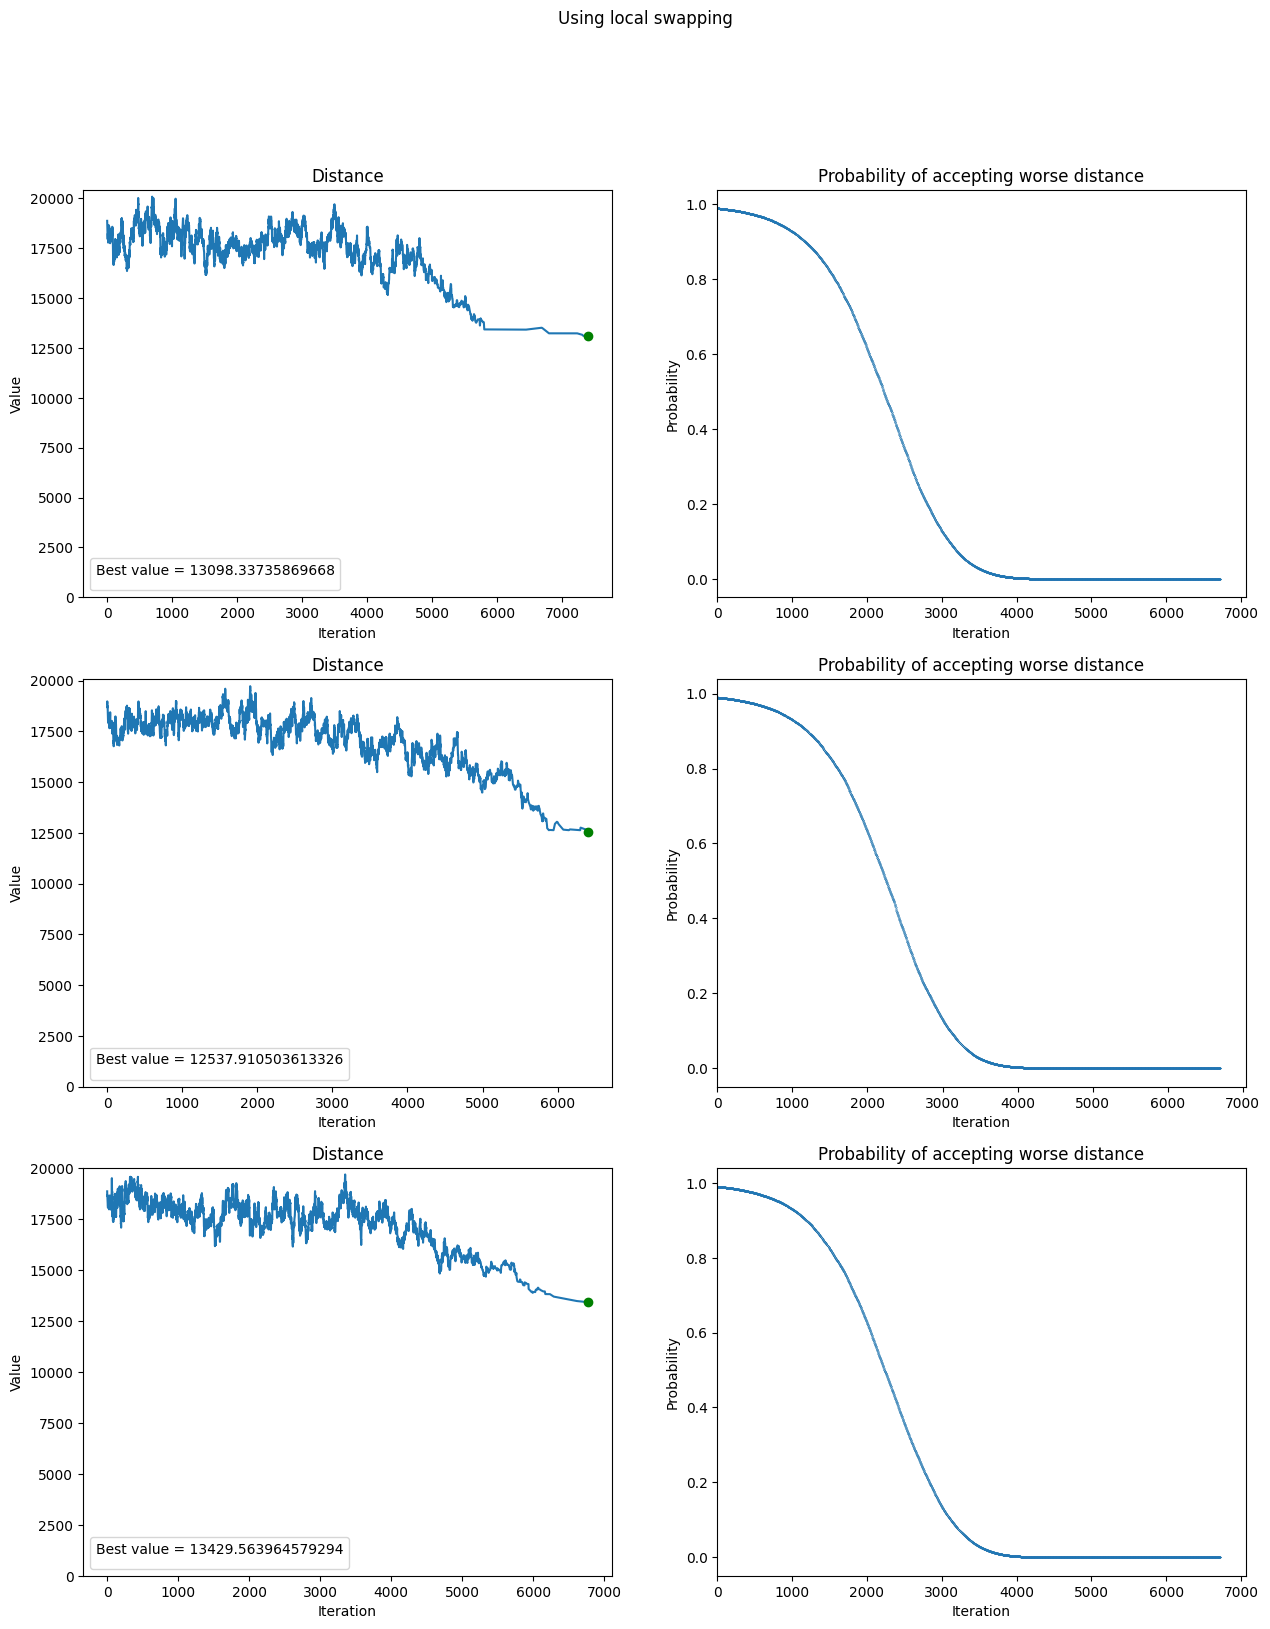

In [331]:
y = normal_distribution(100)
draw_n_plots(3, y, True)
draw_n_plots(3, y, False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2932\3200498337.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


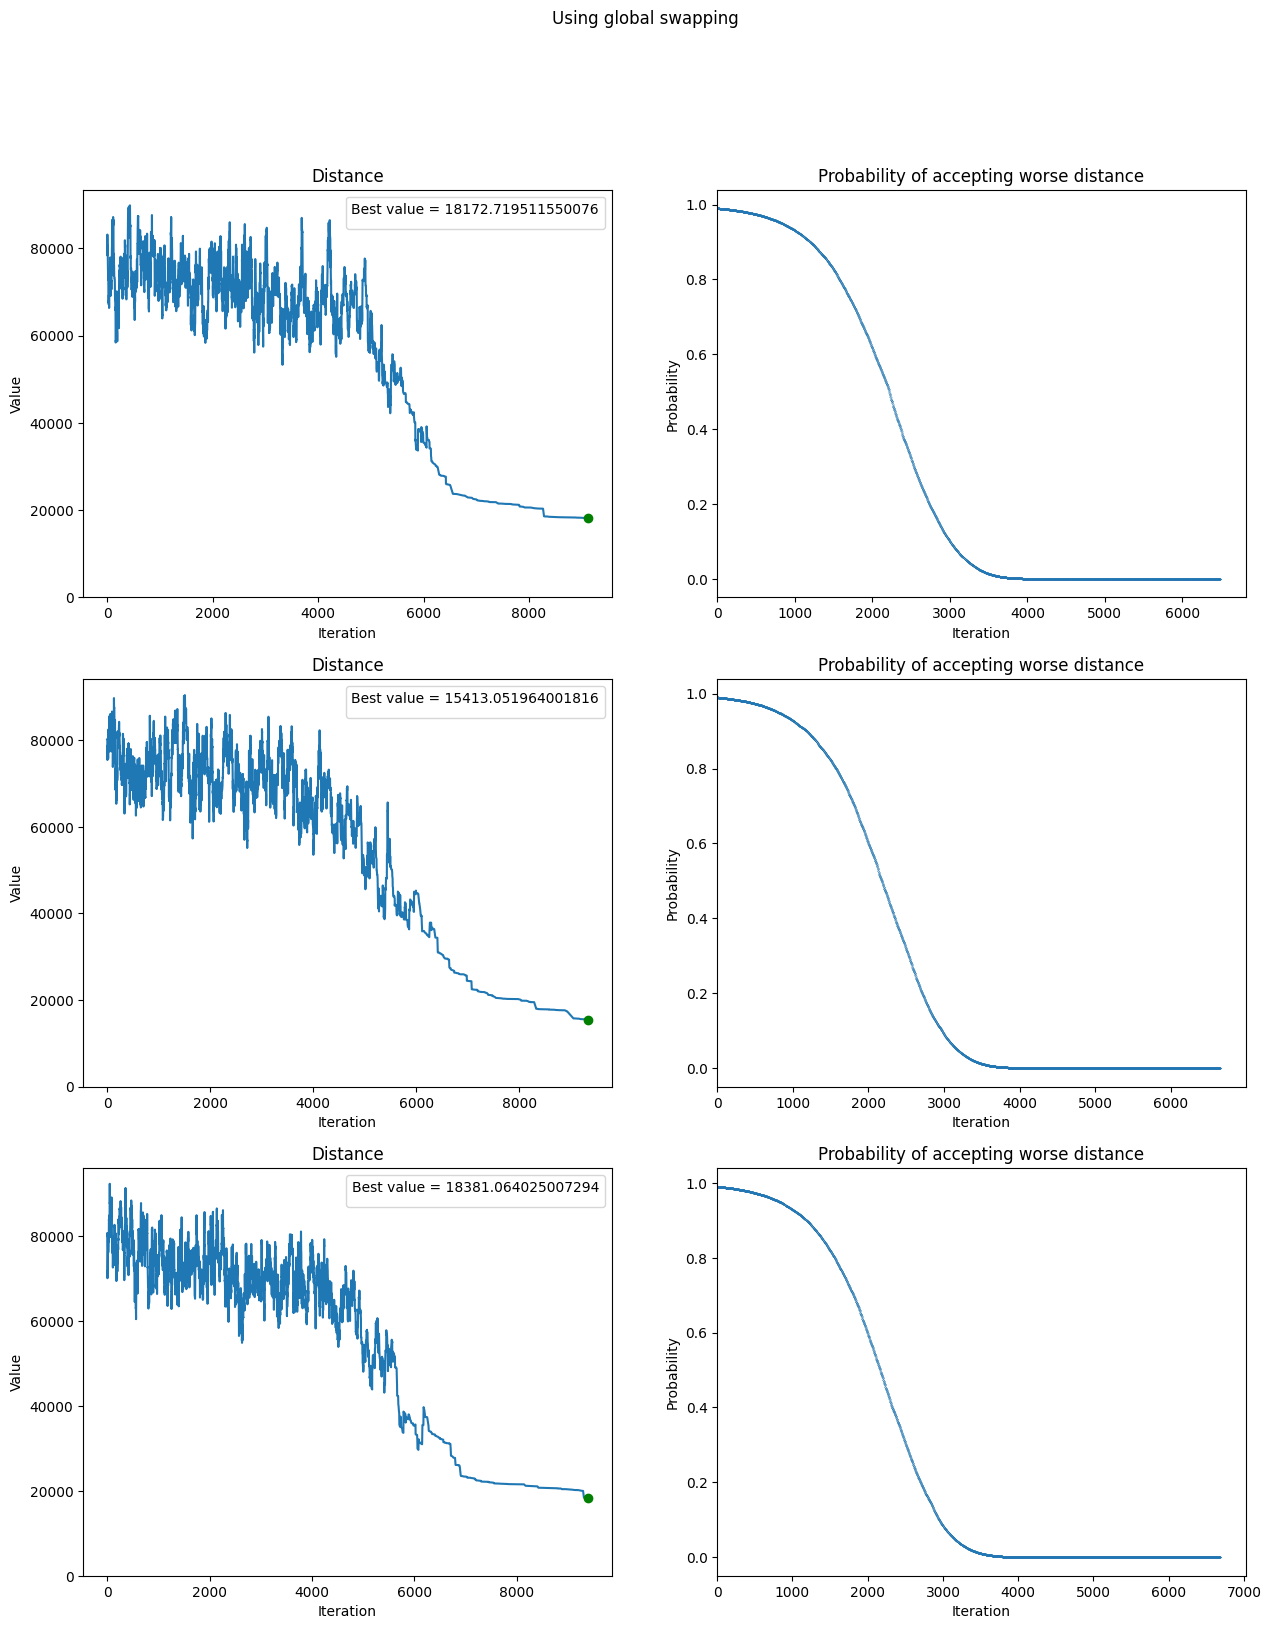

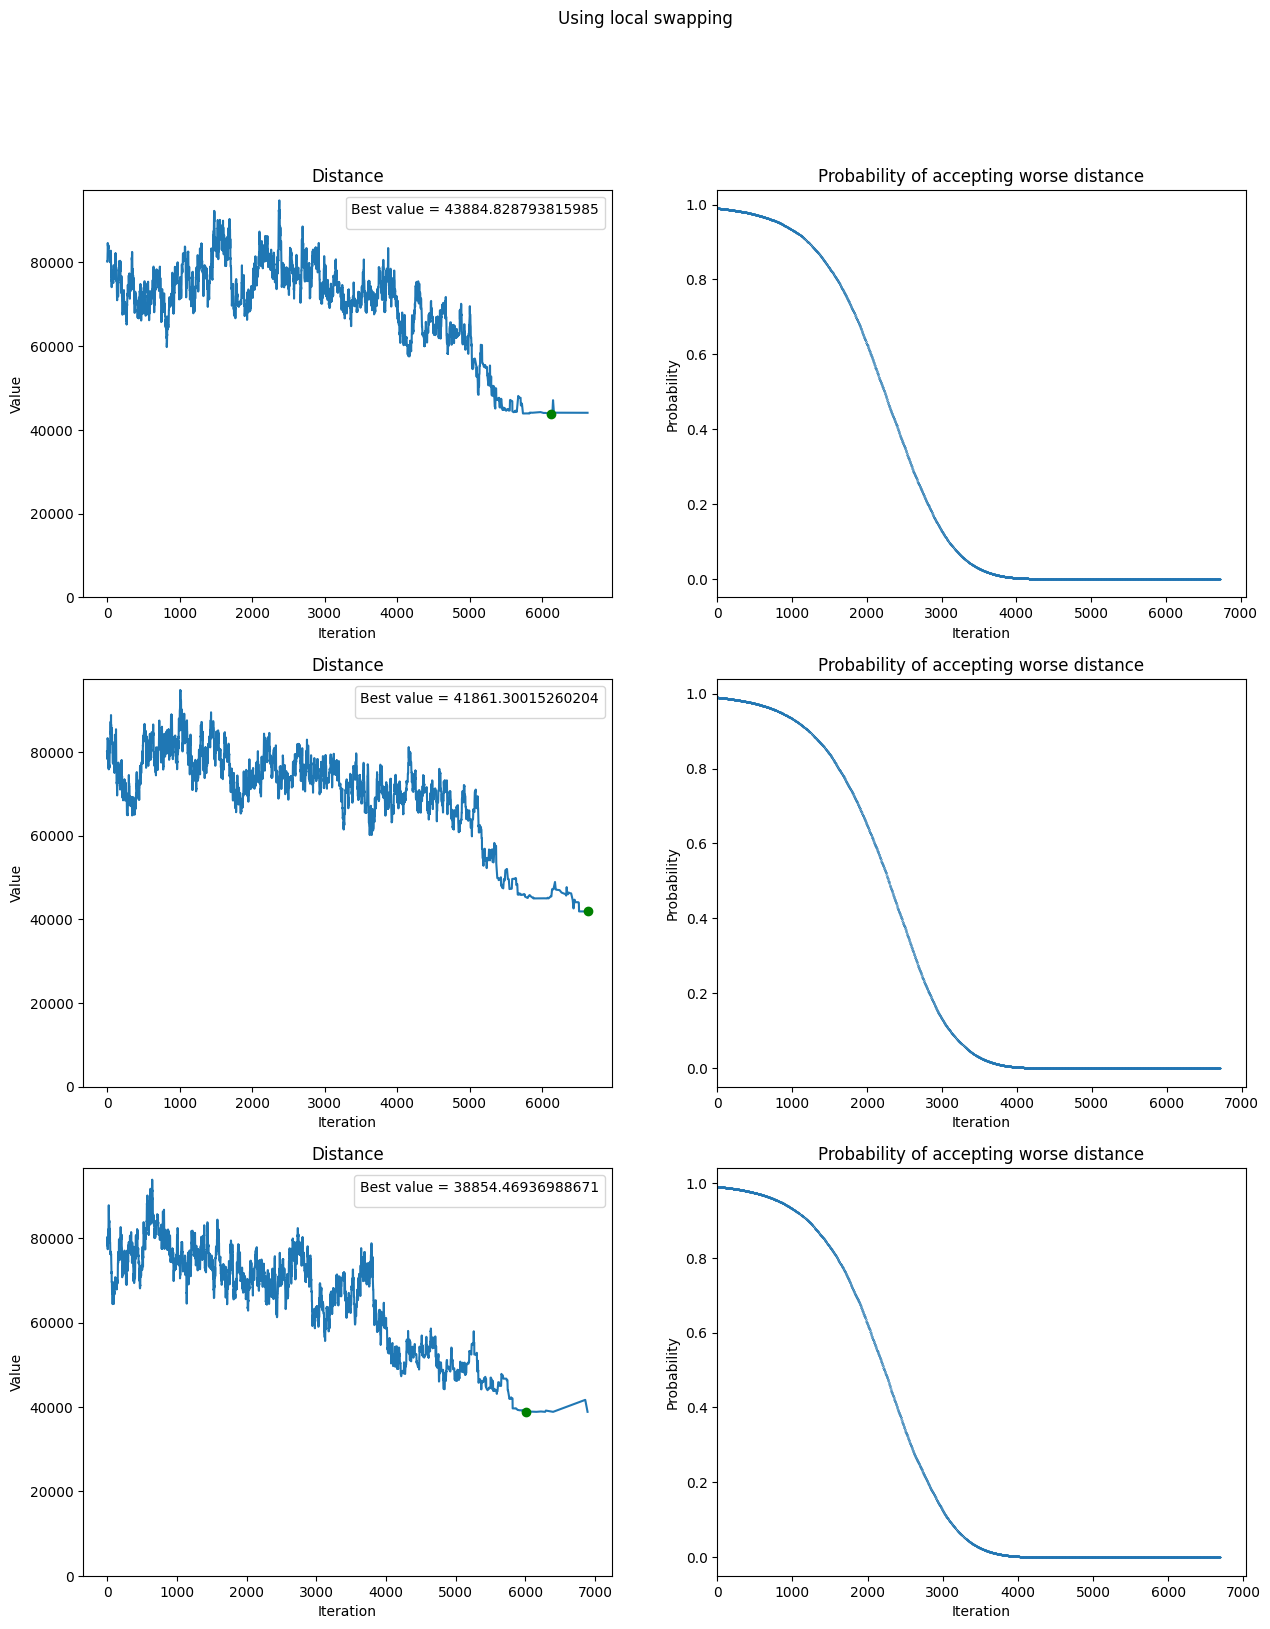

In [332]:
z = cluster_distribution(100, 4)
draw_n_plots(3, z, True)
draw_n_plots(3, z, False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2932\3200498337.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


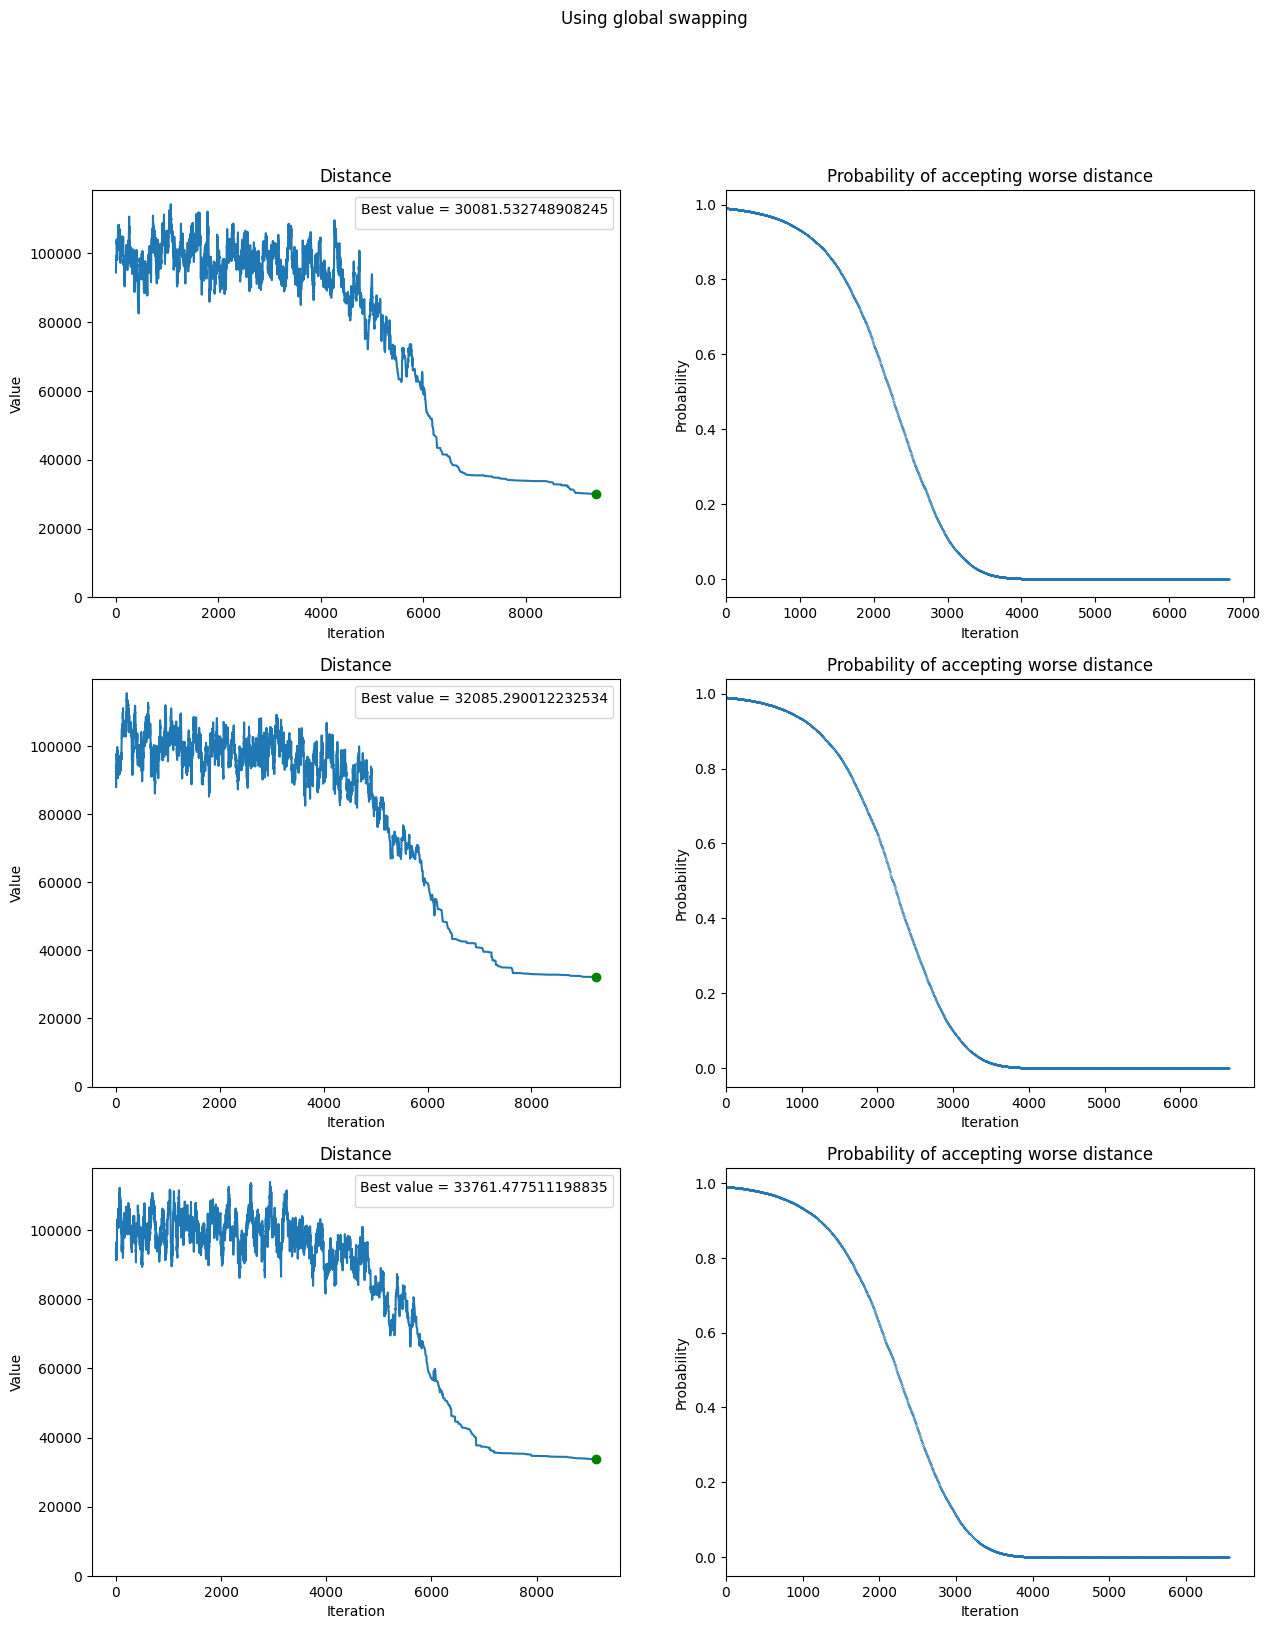

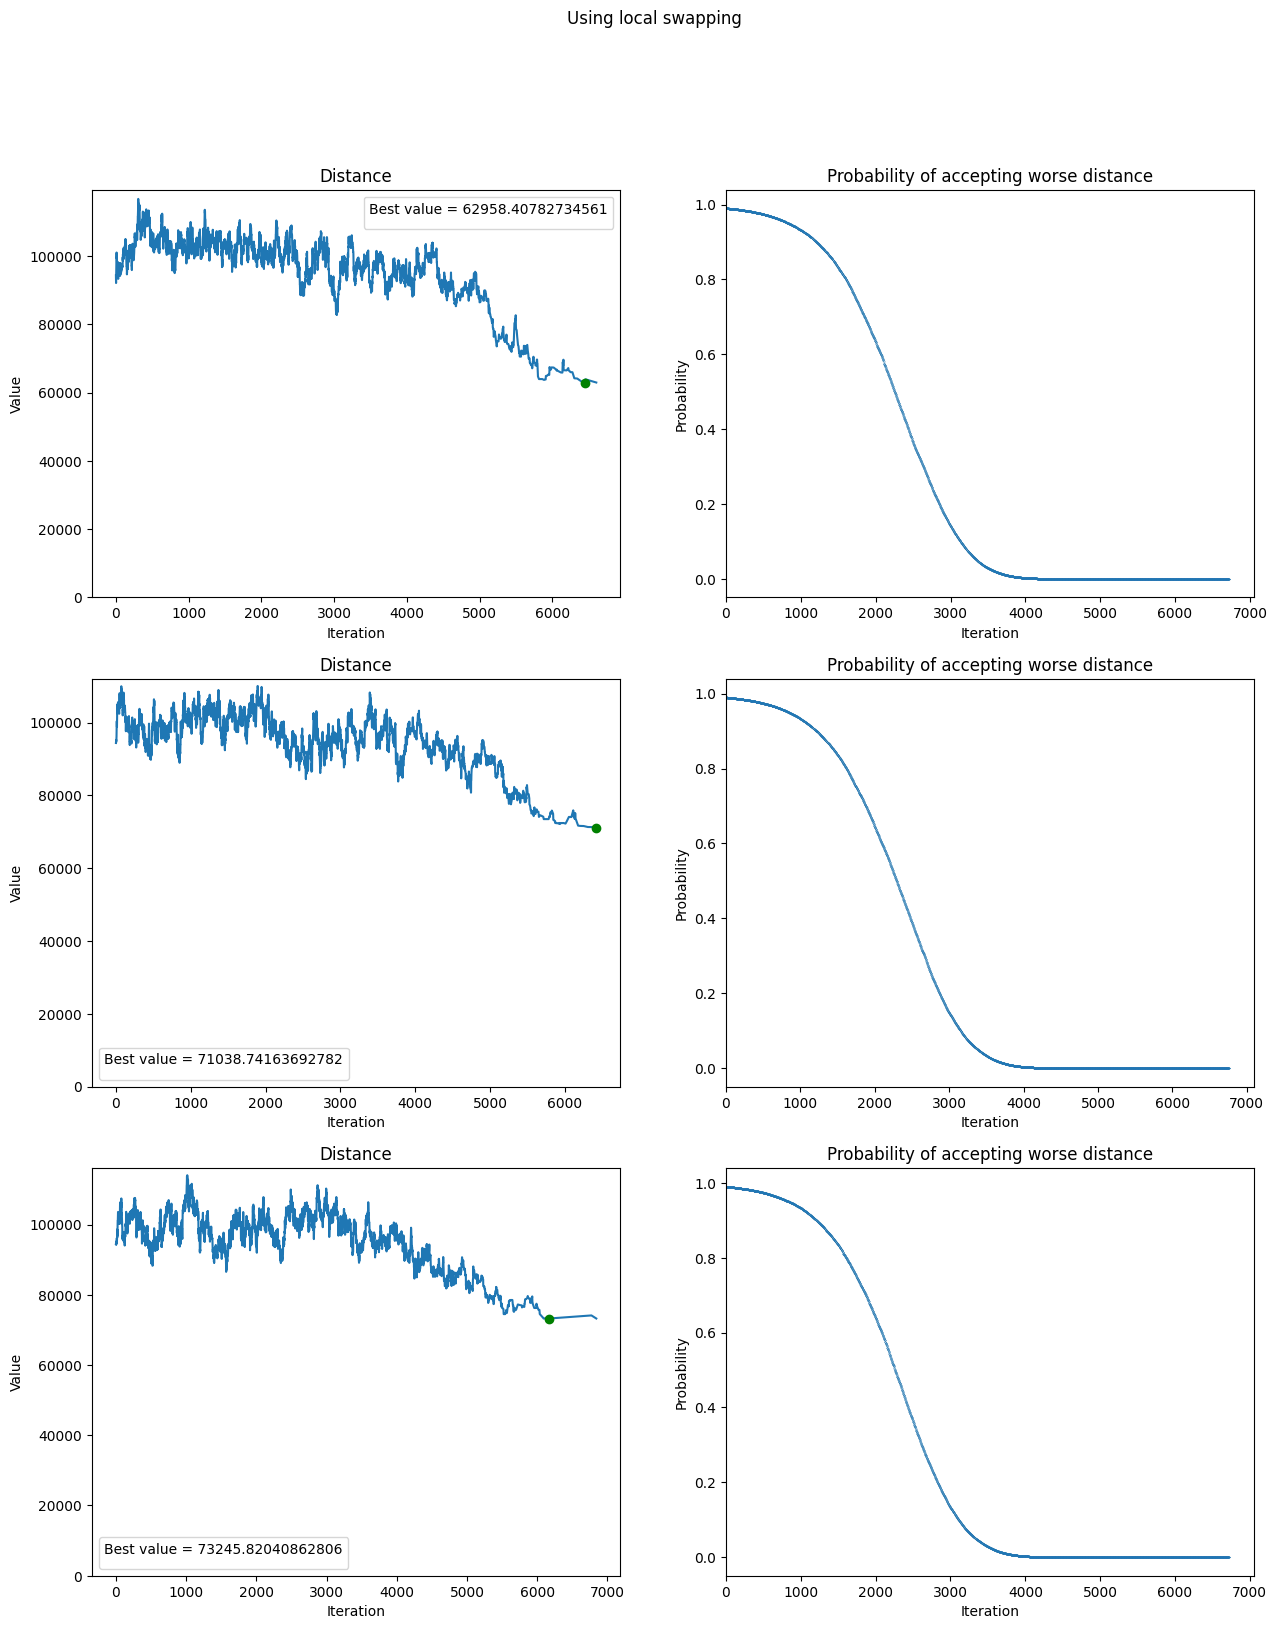

In [333]:
a = cluster_distribution(100, 9)
draw_n_plots(3, a, True)
draw_n_plots(3, a, False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2932\3200498337.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axis[i][0].legend(title=f"Best value = {best_pair[1]}")


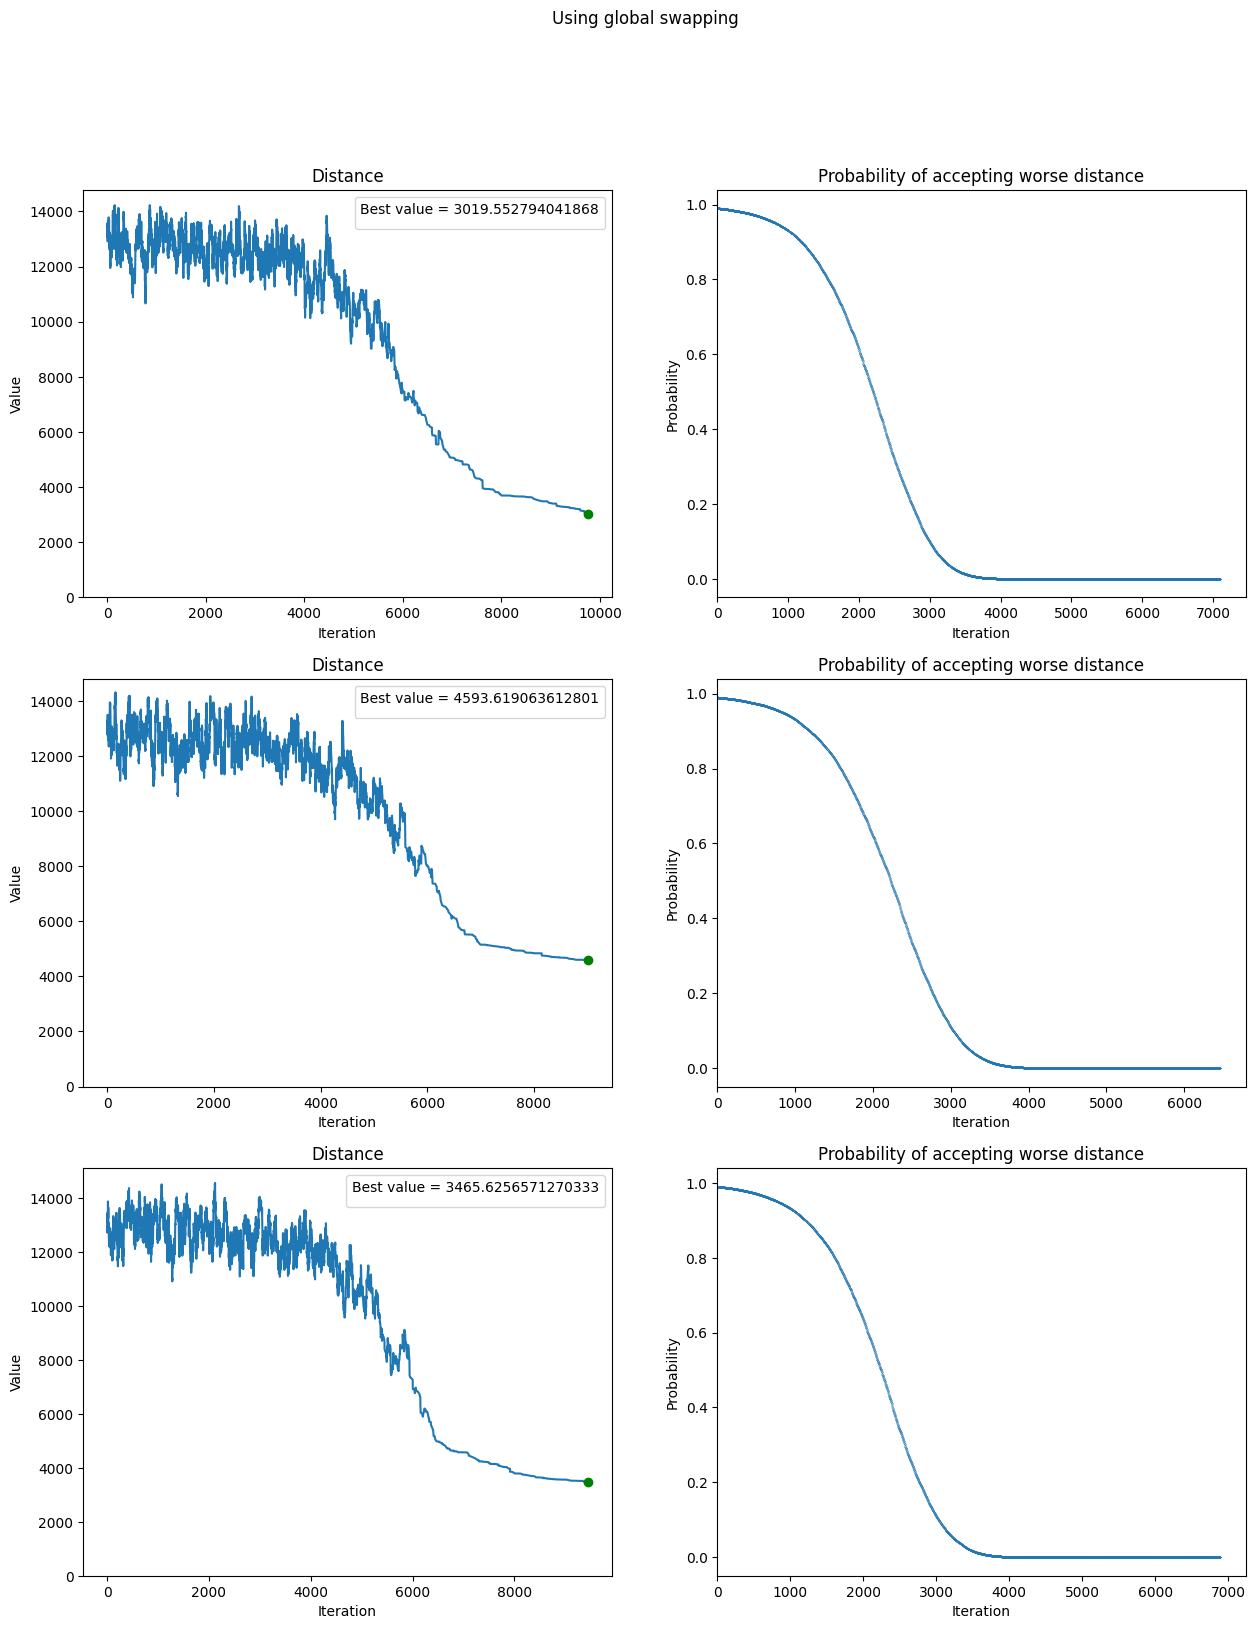

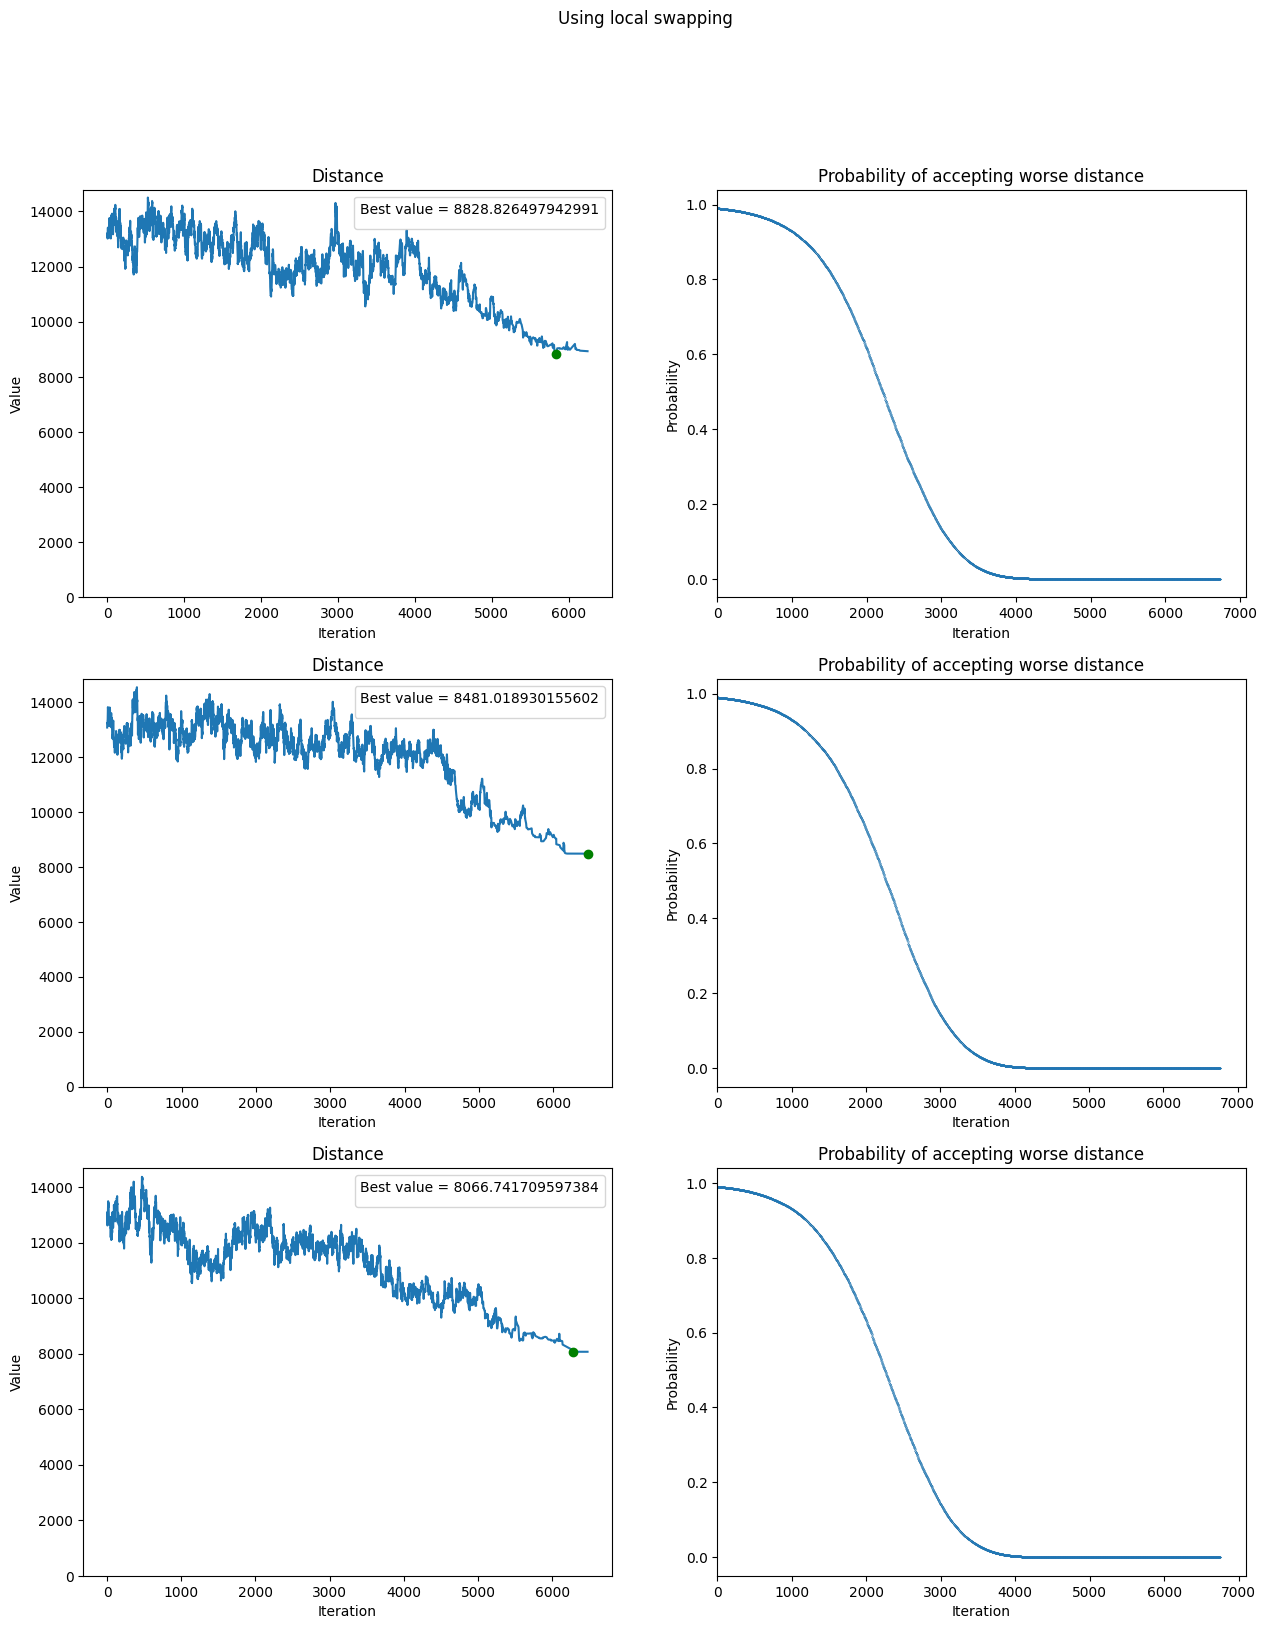

In [334]:
b = circle_distribution(100)
draw_n_plots(3, b, True)
draw_n_plots(3, b, False)

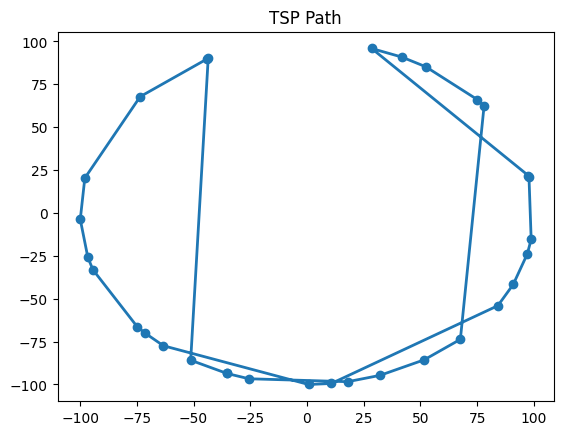

In [335]:
def plot_path(points):
    path = np.vstack([points, points[0]])
    plt.plot(path[:,0], path[:,1], 'o-', lw=2)
    plt.title('TSP Path')
    plt.show()

a = uniform_distribution(20)
b = normal_distribution(10)
c = cluster_distribution(10, 4)
d = cluster_distribution(18, 9)
e = circle_distribution(30)
args, vals, prob_args, probs, best_pair, best_path = TSP(copy(e), big_switch=True)
plot_path(best_path)



2500.257102591148


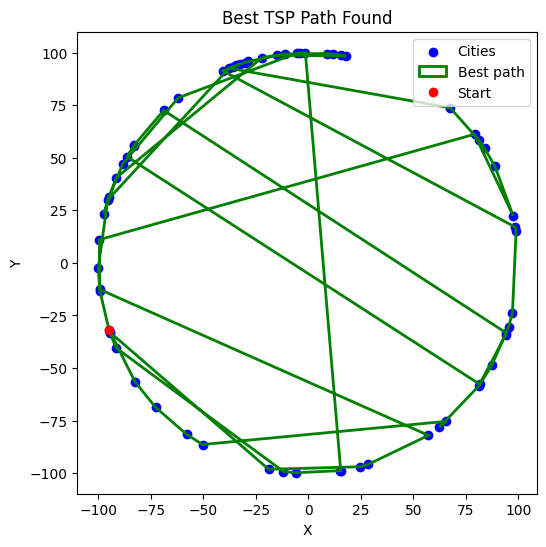

In [336]:
# Run TSP
args, vals, prob_args, probs, best_pair, best_path = TSP(circle_distribution(64), big_switch=True)

# Create plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot points
ax.scatter(best_path[:, 0], best_path[:, 1], color='blue', label='Cities')

# Add best path as polygon
poly = patch.Polygon(best_path, closed=True, edgecolor='green', fill=False, linewidth=2, label='Best path')
ax.add_patch(poly)

# Optional: Annotate starting point
ax.plot(best_path[0][0], best_path[0][1], "ro", label="Start")


print(best_pair[1])
# Beautify plot
ax.set_title("Best TSP Path Found")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
ax.set_aspect('equal')

plt.show()

## **Obraz binarny**

In [17]:
def display_values(array):
    return ((array + 1)*0.5*255).astype(np.uint8)

In [18]:
def binary_image(n, delta = 0.5):
    plane = np.random.binomial(1, delta, (n, n))
    return plane

def pos_neg(n, delta = 0.5):
    return np.random.choice([-1, 1], (n, n))


In [19]:
def Ising_model(array, B=0.3):
    
    def update(array, x, y, B):
        n = len(array)
        total = 0
        for j in range(max(0, y-1), min(y+2, n-1)):
            for i in range(max(0, x-1), min(x+2, n-1)):
                if j == y and i == x: 
                    continue
                total += array[j, i] 
        dE = 2 * array[y, x] * total
        if dE <= 0:
            array[y, x] *= -1
        elif np.exp(-dE*B) > np.random.rand():
            array[y, x] *= -1


    n = len(array)
    for j in range(n):
        for i in range(n):
            update(array, i, j, B)
    return array


In [20]:
images = [pos_neg(512, 0.1)]
for i in range(50):
    images.append(Ising_model(images[-1].copy()))

frames = [Image.fromarray(display_values(img)) for img in images]

frames[0].save('Ising1.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

In [21]:
images = [pos_neg(512, 0.3)]
for i in range(50):
    images.append(Ising_model(images[-1].copy()))

frames = [Image.fromarray(display_values(img)) for img in images]

frames[0].save('Ising3.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

In [22]:
images = [pos_neg(512, 0.4)]
for i in range(50):
    images.append(Ising_model(images[-1].copy()))

frames = [Image.fromarray(display_values(img)) for img in images]

frames[0].save('Ising4.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

## **Sudoku**

In [53]:
def solve(name, T0):
    def read_array(name):
        array = [[0]*9 for _ in range(9)]
        numbers = {1: 9, 2: 9, 3: 9, 4: 9, 5: 9, 6: 9, 7: 9, 8: 9, 9: 9}
        f = open(name, "r")
        for j in range(9):
            for i, c in enumerate(f.readline()):
                if i == 9: break
                try: 
                    array[j][i] = int(c)
                    numbers[int(c)] -= 1
                except ValueError:
                    array[j][i] = c
        f.close()
        return array, numbers
    
    def check(working_array, empty_points):
        mistakes = 0
        for (x, y) in empty_points:
            if len(np.unique(working_array[y])) < 9:
                mistakes += 1
        
            elif len(np.unique(working_array[:, x])) < 9:
                mistakes += 1

            elif len(np.unique(working_array[(y//3)*3: ((y//3) + 1)*3, (x//3)*3: ((x//3) + 1)*3])) < 9:
                mistakes += 1
  
        return mistakes
            
    def fill_with_vector(working_array, vector, empty_spaces):
        new_working_array = deepcopy(working_array)
        for i, (x, y) in enumerate(empty_spaces):
            new_working_array[y][x] = vector[i]
        new_working_array = np.array(new_working_array)
        return new_working_array
    
    def change_one_pair(working_array, empty_spaces):
        new_working_array = deepcopy(working_array)
        (x, y) = empty_spaces[np.random.randint(0, len(empty_spaces))]
        (a, b) = empty_spaces[np.random.randint(0, len(empty_spaces))]
    
        new_working_array[b, a], new_working_array[y, x] = new_working_array[y, x], new_working_array[b, a]
        return new_working_array

    array, numbers = read_array(name)
    working_array = deepcopy(array)
    empty_spaces = [(x, y) for y in range(9) for x in range(9) if array[y][x] == 'x']
    
    vector = []
    for (v, k) in numbers.items():
        for _ in range(k):
            vector.append(v)
    vector = np.array(vector)
    working_array = fill_with_vector(working_array, vector, empty_spaces)

    # print(*working_array, sep='\n')
    # print(empty_spaces)
    seen = []
    mistakes = check(working_array, empty_spaces)  
    seen.append(mistakes)
    k = 1
    while mistakes != 0 and k < 100000000:
        np.random.shuffle(vector)
        new_array = change_one_pair(working_array, empty_spaces)
        new_mistakes = check(new_array, empty_spaces)
        seen.append(new_mistakes)

        if new_mistakes < mistakes:
            mistakes = new_mistakes
            working_array = new_array
        elif T0/np.log(1 + k) > np.random.rand():
            mistakes = new_mistakes
            working_array = new_array

        k += 1
    print(set(seen))
    return mistakes, new_array

print(*solve("sudoku/sudoku2.txt", 100000), sep='\n')
        

KeyboardInterrupt: 